In [121]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from tqdm import tqdm
import warnings

try:
    import hyperfit
except ImportError as e:
    print(e)
    !pip install hyperfit --user
    import hyperfit

try:
    import ligo.skymap.plot
except ImportError as e:
    print(e)
    !pip install ligo.skymap --user
    import ligo.skymap.plot

import os
import re
import hyperfit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#- Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

## Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25`
* `ZWARN = 0`
* Multiple good galaxy center and semimajor axis observations are present.

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')

sgatab = Table.read(sgafits)
sgatab

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,132.3208048632948,2.6948192386790226
55,SGA-2020 55,PGC1203947,1203947,199.7306

### Load all Tully-Fisher Observations from Iron Production

In [4]:
tfpath = '.'
# tfpath = '/global/cfs/cdirs/desi/science/td/pv/'
tffits = os.path.join(tfpath, 'desi_pv_tf_iron_healpix.fits')

#- Open the table and downselect only rows matching the final SGA table
tftab = Table.read(tffits)
num_sga = len(np.unique(tftab['SGA_ID']))

idx = np.in1d(tftab['SGA_ID'], sgatab['SGA_ID'])
tftab = tftab[idx]

tftab

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2394964851949575,210.169700462985,48.4579120631287,10727,main,0.0262232536365811,5.08507548212057e-05,4,0.291733368998393,iron/healpix/main/bright/107/10727/redrock-main-bright-10727.fits,EXT,1027002,210.16970046298474,48.45791206312868
2847787880284162,190.565296411199,38.5309015723587,10809,main,1.01189685942238,0.000107372470173326,4,5.11678498983383,iron/healpix/main/dark/108/10809/redrock-main-dark-10809.fits,EXT,446318,190.56529641119872,38.53090157235874
2394736090415107,198.041550782624,35.7143059310507,10474,main,1.39238514531392,0.00011895994280197,0,13.4195505976677,iron/healpix/main/bright/104/10474/redrock-main-bright-10474.fits,EXT,320783,198.04155078262374,35.714305931050696
2407930229948419,198.041550782624,35.7143059310507,10474,main,0.712101901046581,8.01885285295481e-05,4,2.04660725966096,iron/healpix/main/dark/104/10474/redrock-main-dark-10474.fits,EXT,320783,198.04155078262374,35.714305931050696
2847734881058823,198.051517321512,35.6292628780548,10474,main,1.54371459041884,0.000139452552307324,4,2.56803219020367,iron/healpix/main/dark/104/10474/redrock-main-dark-10474.fits,EXT,320783,198.05151732151202,35.62926287805476
2407864991744014,190.399569329198,32.5304436669536,10761,main,0.00154087114844486,5.70509534207211e-06,0,749.824635429017,iron/healpix/main/dark/107/10761/redrock-main-dark-10761.fits,EXT,977015,190.39956932919756,32.5304436669536
2847669642854414,190.399569329198,32.5304436669536,10761,main,0.00156240158297109,8.03875353156571e-06,0,364.915096621779,iron/healpix/main/dark/107/10761/redrock-main-dark-10761.fits,EXT,977015,190.39956932919756,32.5304436669536
2407864991744011,190.488447388269,32.5369519878869,10761,main,0.00187035286047011,1.3675361854664e-06,0,24327.5303279283,iron/healpix/main/dark/107/10761/redrock-main-dark-10761.fits,EXT,977015,190.48844738826932,32.53695198788685
2847669642854411,190.488447388269,32.5369519878869,10761,main,0.00186364286244594,1.59149654119913e-06,0,20291.0995003253,iron/healpix/main/dark/107/10761/redrock-main-dark-10761.fits,EXT,977015,190.48844738826932,32.53695198788685


### Separate the Iron Data into Center and Off-Center Observations

Use the SGA file matched to iron data and look in the iron measurements to find center and off-center observations. Use that to compute velocities.

In [5]:
tftab['SKY_FIBER_DIST'] = 0.
tftab['SKY_FIBER_DIST_R26'] = 0.

sga_ids = np.unique(tftab['SGA_ID'])

#- For each galaxy with >= 1 observation, calculate the distance to all targets observed
for sga_id in tqdm(sga_ids):
    #- ID all targets on this galaxy
    tgt_idx = tftab['SGA_ID'] == sga_id
    tgt_coords = SkyCoord(ra=tftab['RA'][tgt_idx], dec=tftab['DEC'][tgt_idx], unit='degree')

    #- Find the galaxy coordinates in the SGA catalog
    sga_idx = np.in1d(sgatab['SGA_ID'], sga_id)
    sga_coords = SkyCoord(ra=sgatab['RA'][sga_idx], dec=sgatab['DEC'][sga_idx], unit='degree')

    #- Compute the angular separation and store in the Iron table
    sep2d = tgt_coords.separation(sga_coords)
    tftab['SKY_FIBER_DIST'][tgt_idx] = sep2d
    tftab['SKY_FIBER_DIST_R26'][tgt_idx] = 2 * sep2d.to('arcmin')/(sgatab['D26'][sga_idx] * u.arcmin)

100%|█████████████████████████████████████| 10278/10278 [00:05<00:00, 1753.60it/s]


In [6]:
#- Separate the center and off-center observations
is_center_obs = tftab['SKY_FIBER_DIST_R26'] < 0.1
tf_centers = tftab[is_center_obs]
tf_offcent = tftab[~is_center_obs]

### Compute the rotational velocities

Rotational velocities are computed here for all off-center observations in the TF Iron catalog which have SGA IDs matching our SGA table in `SGA-2020_iron_Vrot.fits`.

In [7]:
sga_ids = np.unique(tf_centers['SGA_ID'])

tf_offcent['V_ROT'] = np.nan
tf_offcent['V_ROT_ERR'] = np.nan

for sga_id in tqdm(sga_ids):
    #- Identify all off-center targets on this galaxy
    obs_idx = tf_offcent['SGA_ID'] == sga_id

    #- Find the corresponding galaxy in the SGA catalog
    sga_idx = sgatab['SGA_ID'] == sga_id

    #- Compute rotational velocity
    z_center = np.mean(sgatab['Z_DESI'][sga_idx])
    z_var = sgatab['ZERR_DESI'][sga_idx]**2

    tf_offcent['V_ROT'][obs_idx] = c_kms*(tf_offcent['Z'][obs_idx] - z_center)
    tf_offcent['V_ROT_ERR'][obs_idx] = c_kms*np.sqrt(tf_offcent['ZERR'][obs_idx]**2 + z_var)

    #- Correct rotational velocities for inclination angle
    cosi2 = (sgatab['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    if cosi2 < 0:
        cosi2 = 0   # handle case where b/a < q0
    tf_offcent['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))

100%|█████████████████████████████████████| 10278/10278 [00:02<00:00, 3922.27it/s]


### Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* $i > 45^\circ$
* Spiral-type morphology
* [Passed visual inspection - applied in SV]

In [9]:
#- Velocity cut
is_good_velo = (sgatab['V_0p4R26'] > 10) & (sgatab['V_0p4R26'] < 1000)

#- Inclination cut
q0 = 0.2
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral but not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i, morph in enumerate(sgatab['MORPHTYPE']):
    try:
        if morph[0] == 'S' and morph[:2] != 'S0':
            is_good_morph[i] = True
    except IndexError as e:
        continue

#- Apply the Vmin cut on galaxies with multiple observations,
#  which requires using the extracted velocities from the table of iron TF measurements
is_good_dv = np.ones_like(is_good_velo, dtype=bool)
sga_ids = sgatab['SGA_ID']
for i, sga_id in enumerate(sga_ids):
    #- ID all galaxies on this target
    obs_idx = tf_offcent['SGA_ID'] == sga_id
    nobs = np.sum(obs_idx)

    if nobs > 1:
        vmin = np.min(np.abs(tf_offcent['V_ROT'][obs_idx]))
        vmax = np.min(np.abs(tf_offcent['V_ROT'][obs_idx]))

        diff_matrix = np.abs(tf_offcent['V_ROT'][obs_idx]).reshape(nobs, 1) - np.abs(tf_offcent['V_ROT'][obs_idx]).reshape(1, nobs)
        diff_matrix_norm = diff_matrix/vmin

        if np.any(np.abs(diff_matrix_norm) > 5.):
            is_good_dv[i] = False

#- Combine selections:
is_good_sga = is_good_velo & is_good_incl & is_good_morph & is_good_dv

SGA obs.                                : 75152
$10 < V_\mathrm{rot} < 1000$            : 10278
$\Delta V/V_\mathrm{min}>5$             : 9648
Spiral                                  : 5936
All Cuts                                : 4619


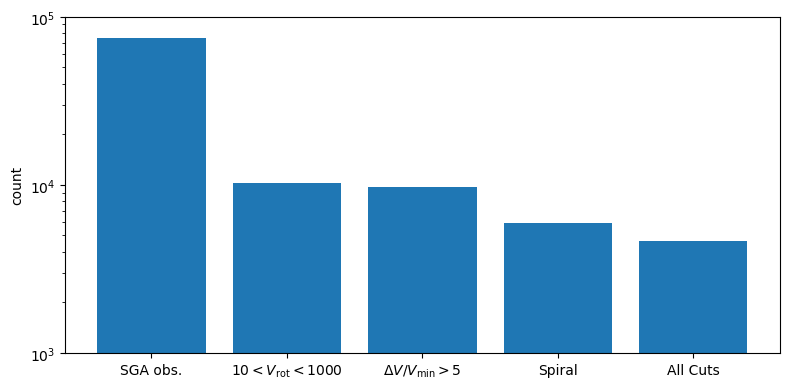

In [11]:
data = {
    'SGA obs.' : num_sga,
    r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    'Spiral' : np.sum(is_good_morph),
    'All Cuts' : np.sum(is_good_sga)
}
names = list(data.keys())
values = list(data.values())

for _n, _v in zip(names, values):
    print(f'{_n:40s}: {_v:d}')

fig, ax = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)
ax.bar(names, values)
ax.set(ylabel='count', yscale='log', ylim=[1e3,1e5]);

## Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in (*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*)[https://iopscience.iop.org/article/10.3847/1538-4357/ab901c], ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [12]:
clusters = Table.read('../Tully15-Table3.fits')
clusters

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
,,,,deg,deg,[Lsun],km / s,mag,km / s,Mpc,km / s,Msun,
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1.710e+15,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.440,707,5.290e+14,1.00
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.520,746,6.230e+14,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1.770e+15,2.26
1,100005,61,36487,92.0255,-10.4950,12.78,6987,34.22,707,1.560,766,6.730e+14,1.58
1,100006,85,31478,139.4478,-37.6063,12.48,4099,33.06,648,1.198,588,3.050e+14,1.14
1,100007,86,56962,108.5182,49.0878,13.52,11603,35.32,1261,2.821,1385,3.980e+15,3.30
1,100008,65,39600,67.2953,3.2390,11.94,1054,30.11,209,0.745,366,7.330e+13,1.00


## Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [13]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

In [234]:
sga_clusters = {}
n_cluster_min = 15

for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
    nest_id = cluster['Nest']
    
    #- Sky coordinates of clusters
    cls_coord = SkyCoord(cluster['SGLON'], cluster['SGLAT'], unit='deg', frame='supergalactic')

    #- Cluster turnaround radii, velocity dispersions, and distance moduli.
    R2t = cluster['R2t']
    sigP = cluster['sigP']
    mu = cluster['DM']

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6)

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5)  & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])

100%|██████████████████████████████████████| 25474/25474 [00:38<00:00, 660.40it/s]


In [235]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100007  20 galaxies
 2  100058  21 galaxies
 3  100067  30 galaxies
 4  100282  24 galaxies
 5  101400  23 galaxies
 6  101788  20 galaxies
 7  103182  27 galaxies


### Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

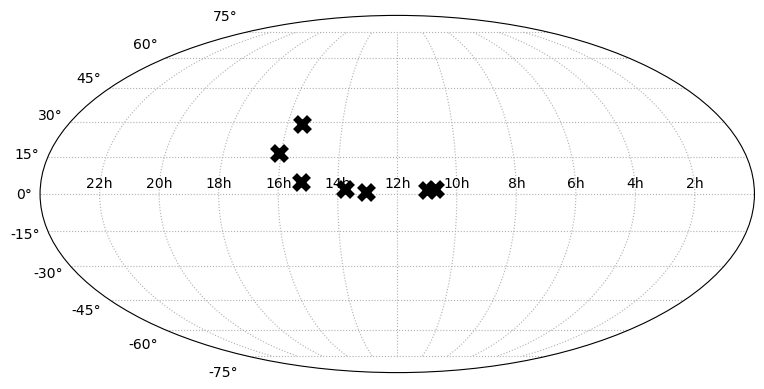

In [236]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
# ax = plt.subplot(111, projection='mollweide')
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':')

In [237]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 781 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (206.10730715, 2.1097726)>
23120.647901755987 +/- 1693 km/s


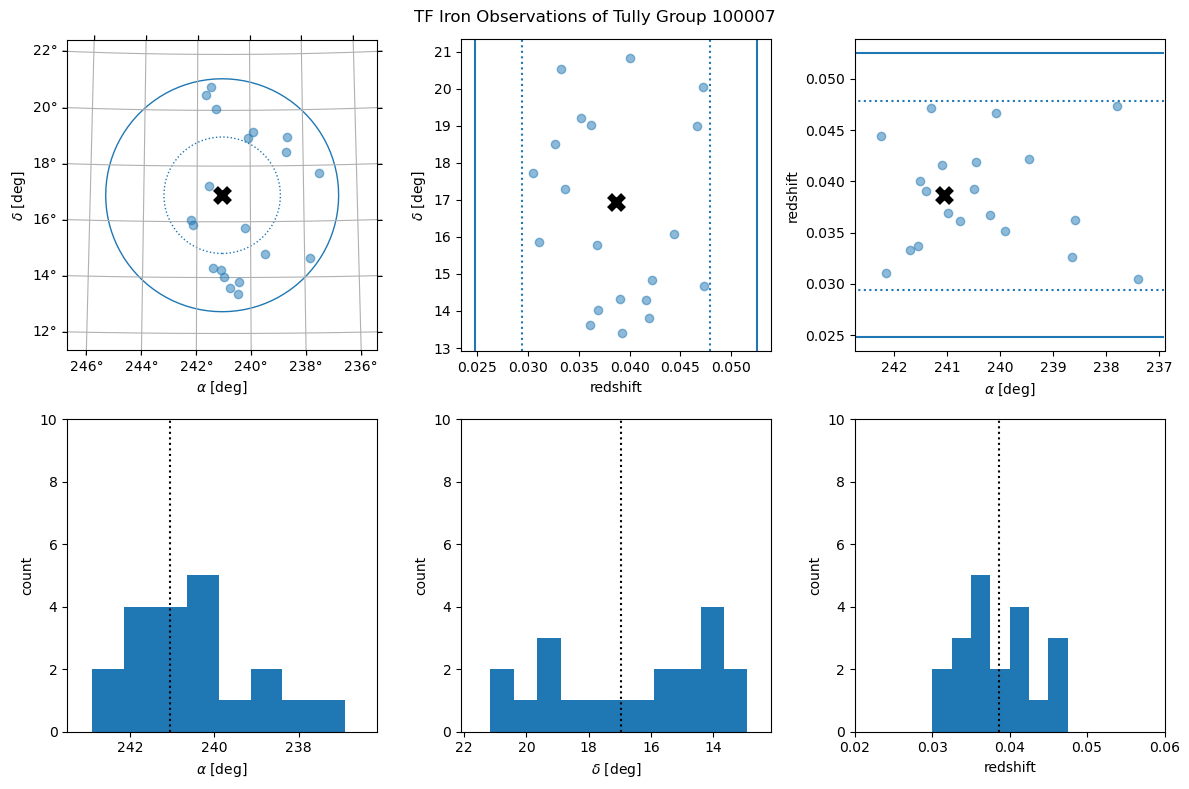

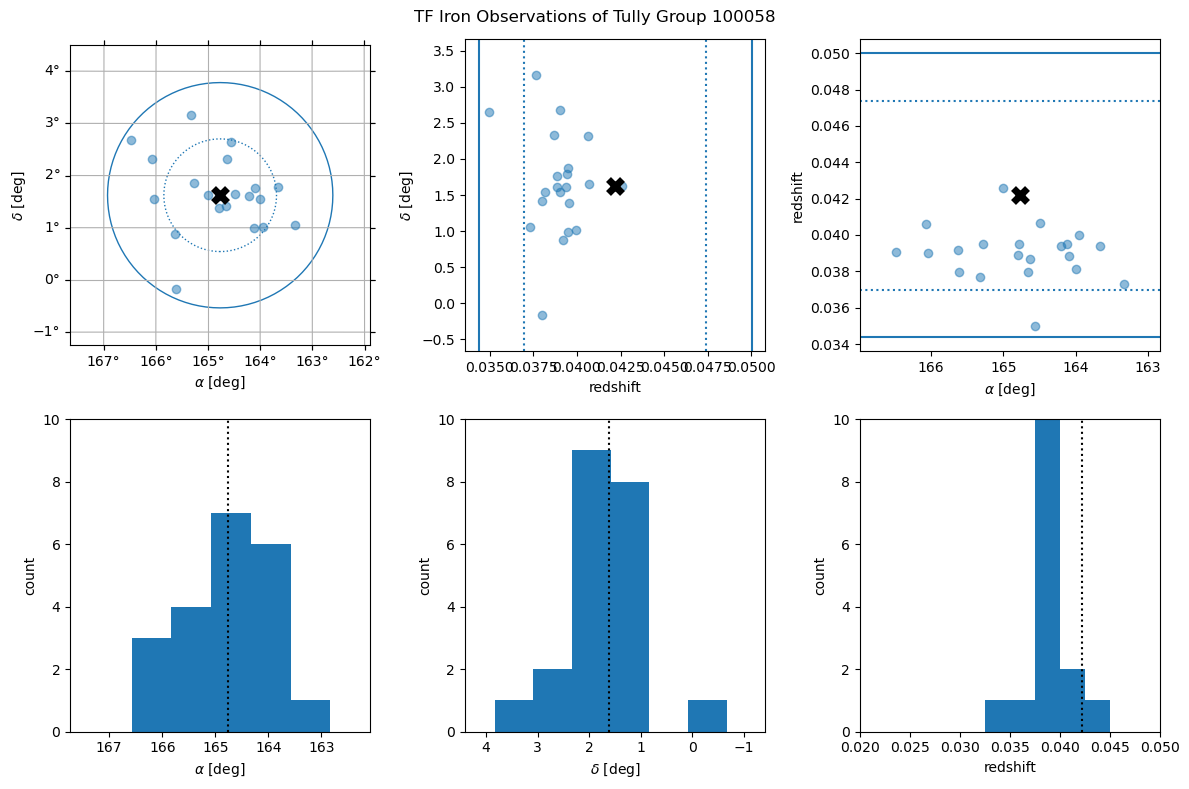

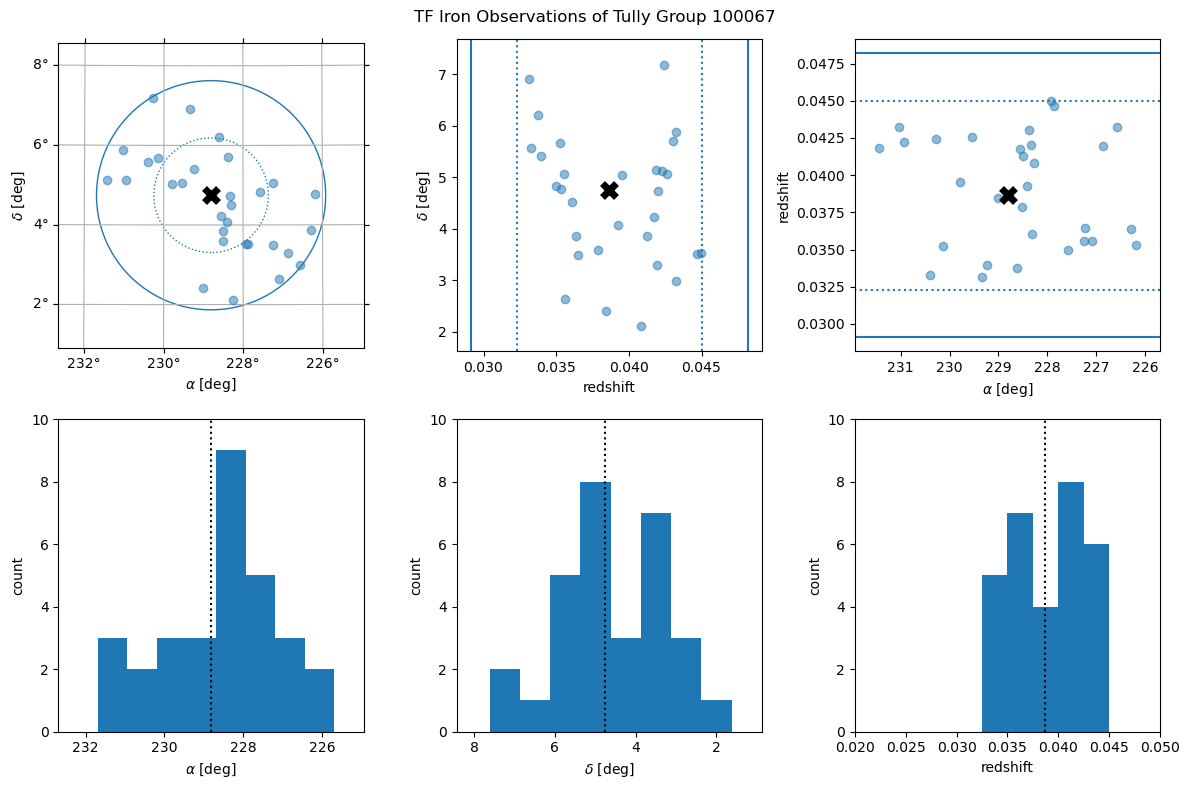

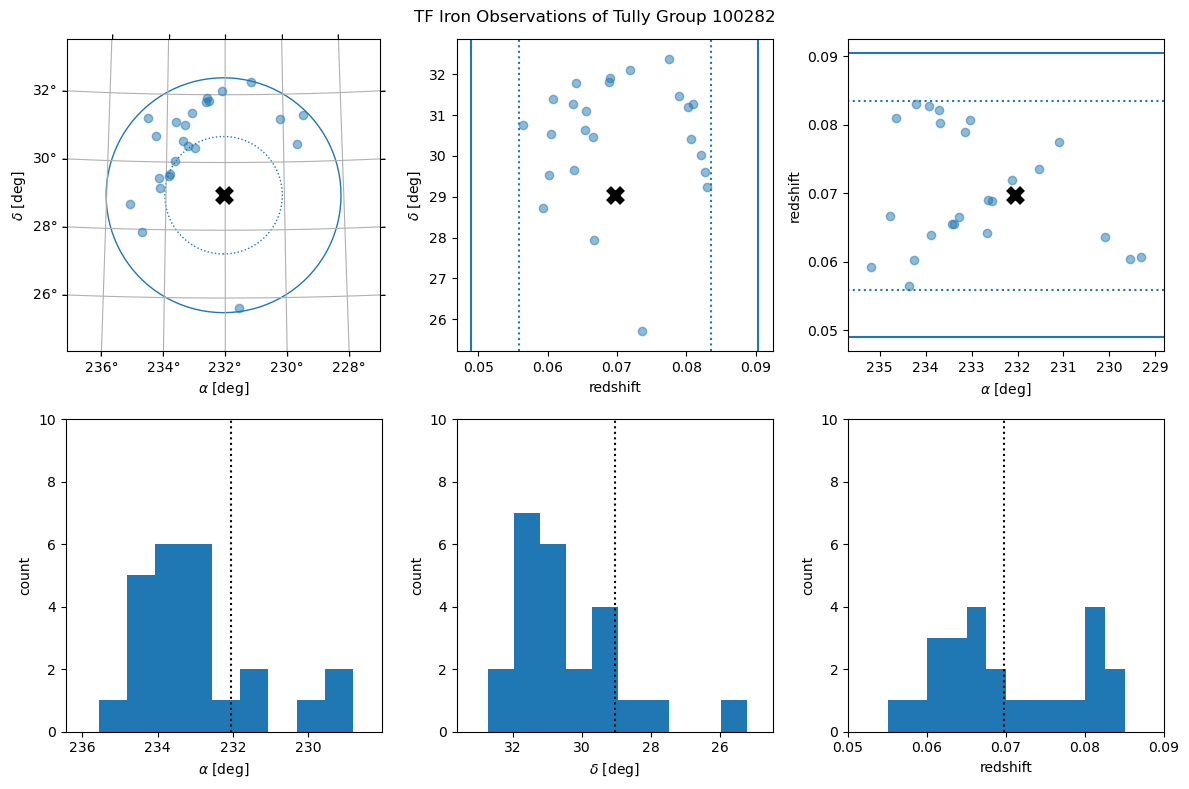

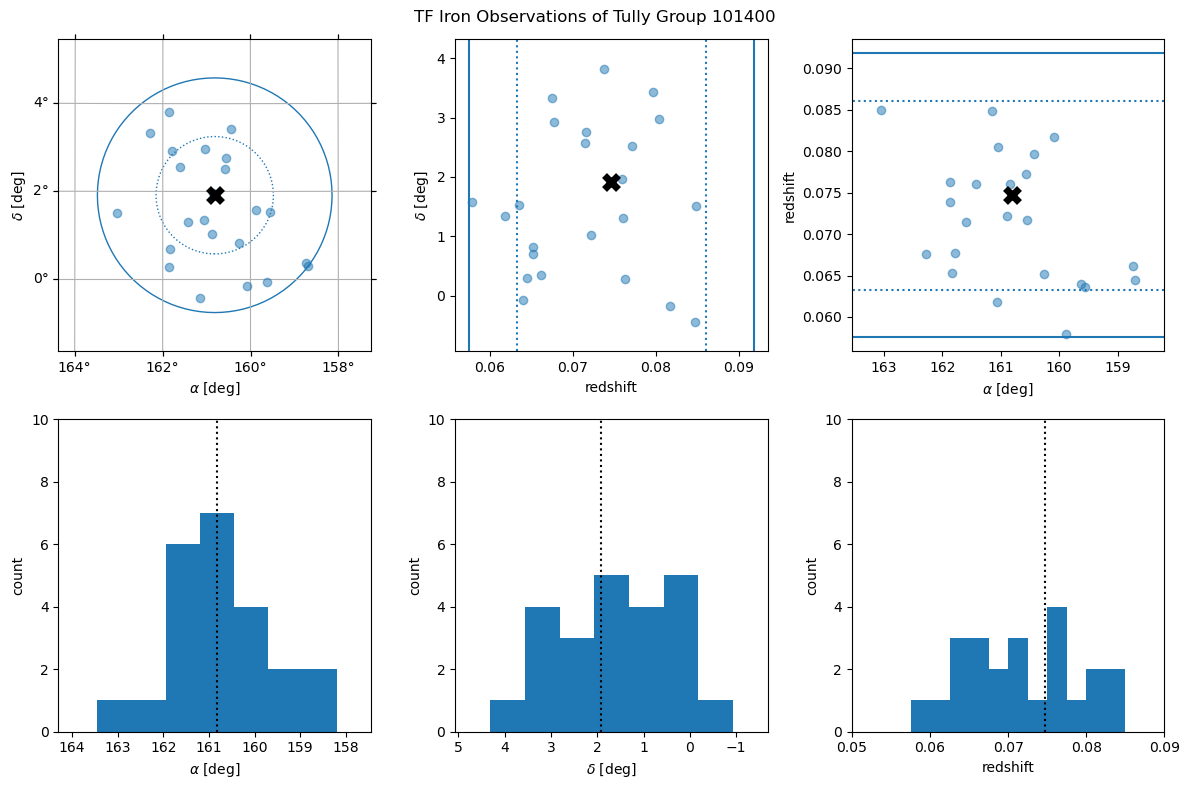

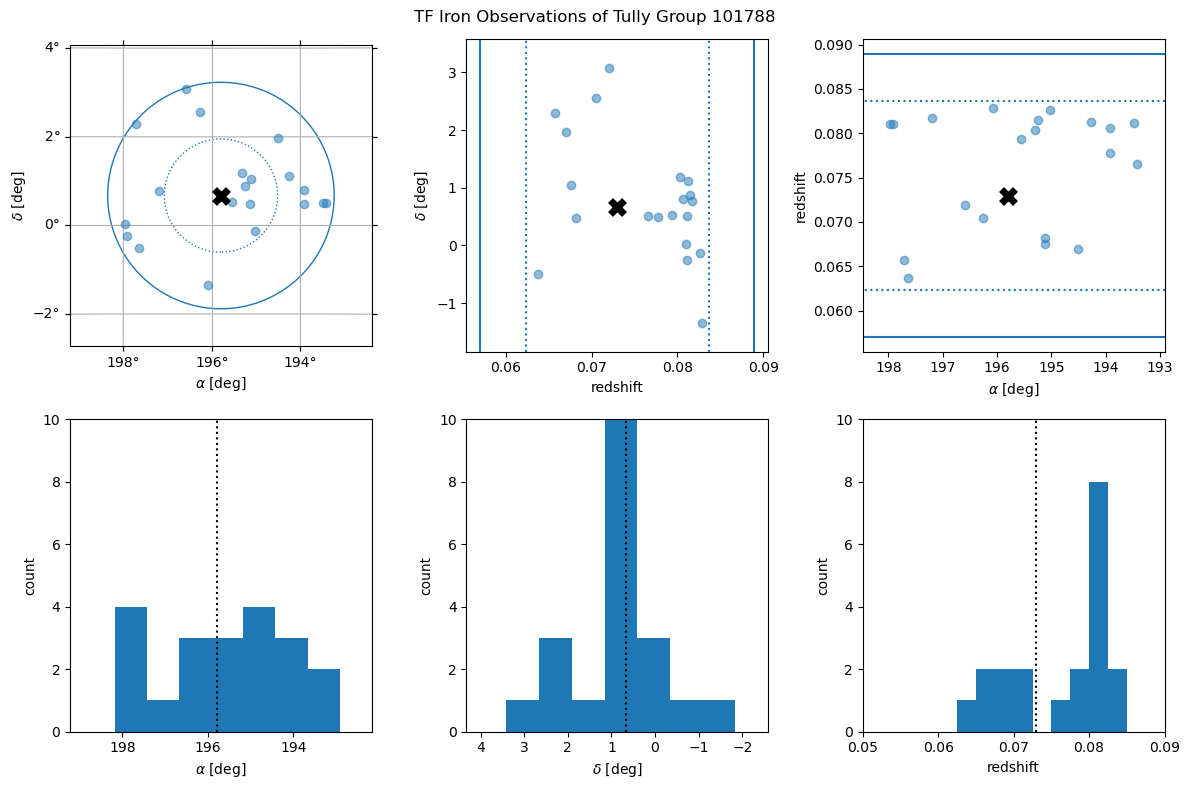

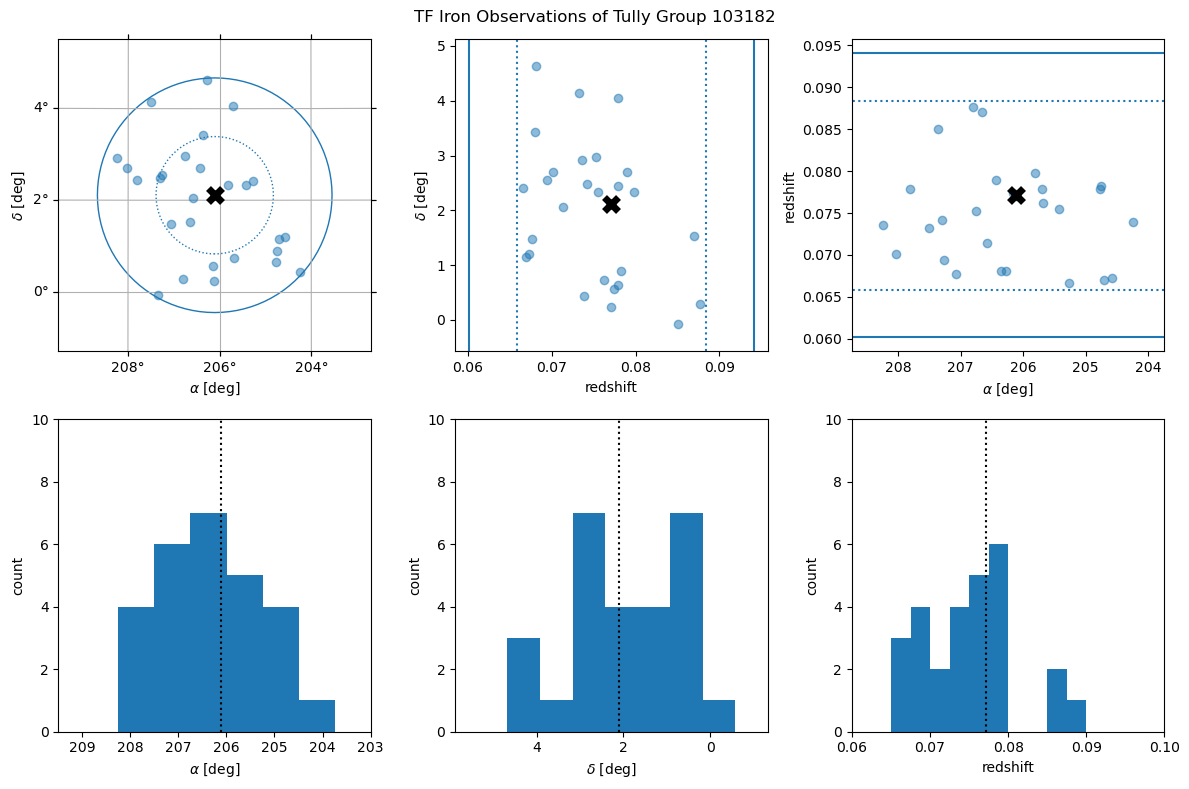

In [238]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])